In [614]:


import _init_paths
from PIL import Image
import numpy as np
import cv2
import random
import copy

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
from vcl.models.vqvae import *
from vcl.models.trackers import *
from vcl.utils import *
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])
        
visualizer = Correspondence_Visualizer(mode='flow')
visualizer_hr = Correspondence_Visualizer(mode='flow', scale=64)



def main(x1, x2, model, frame1, frame2, gt):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    visualizer.visualize([enc1, enc2], [x1, x2], [frame1, frame2], gt)
    # visualize_correspondence_quant(enc1, enc2, sample_idx, frame1, frame2, scale=32)

def main_hr(x1, x2, model, frame1, frame2, gt):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    visualizer_hr.visualize([enc1, enc2], [x1, x2], [frame1, frame2], gt)

In [615]:
## sample frame
import os.path as osp
import glob


# sample_video_idx = 92
sample_video_idx = random.randint(0, 300)
sample = {}
sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg')))


frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]
video_name = sample['frames_path'][0].split('/')[-2]


frame1 = cv2.imread(sample['frames_path'][frame_idx])[:,:,::-1]
frame2 = cv2.imread(sample['frames_path'][frame_idx+1])[:,:,::-1]
gt = cv2.imread(sample['frames_path'][frame_idx].replace('JPEGImages', 'Flows_s256'))


frame1 = cv2.resize(frame1, (256,256))
frame2 = cv2.resize(frame2, (256,256))
gt = cv2.resize(gt, (256,256))[:,:,1:].astype(np.float32) / 255 - 0.5


print('sample frames from {}'.format(sample['frames_path'][0]))

x1_rgb = preprocess_(frame1, mode='rgb')
x2_rgb = preprocess_(frame2, mode='rgb')

x1_lab = preprocess_(frame1, mode='lab')
x2_lab = preprocess_(frame2, mode='lab')

sample frames from /home/lr/dataset/YouTube-VOS/2018/train/JPEGImages/8be56f165d/00040.jpg


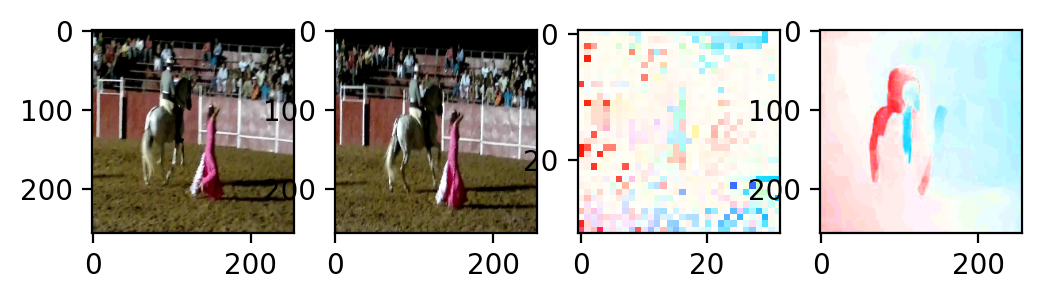

In [616]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    test_cfg=dict(),
    train_cfg=dict()
    )

params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_mast_3/epoch_3200.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)


model = model.cuda()
model.eval()
main(x1_lab, x2_lab, model, frame1, frame2, gt)

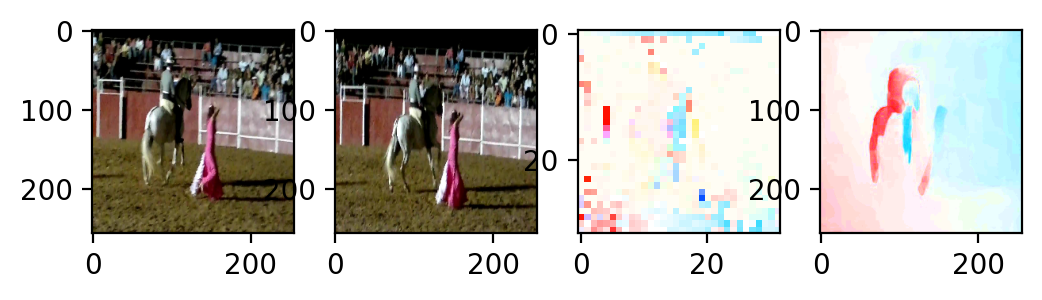

In [617]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_mast/epoch_3200.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
main(x1_lab, x2_lab, model, frame1, frame2, gt)

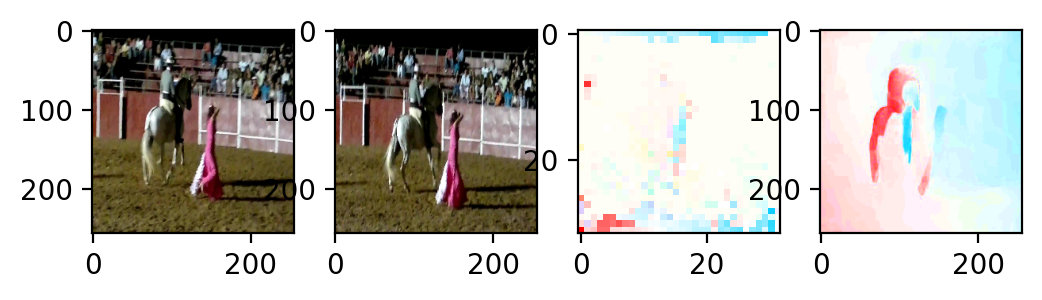

In [618]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_38/epoch_3200.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
main(x1_lab, x2_lab, model, frame1, frame2, gt)

In [619]:

# model = VanillaTracker(
#     backbone=dict(type='ResNet', depth=50, strides=(1, 2, 1, 1), out_indices=(2, ), pretrained='/home/lr/models/ssl/vcl/vfs_pretrain/r50_nc_sgd_cos_100e_r5_1xNx2_k400-d7ce3ad0.pth'),
#     test_cfg=dict(),
#     train_cfg=dict()
#     )

# # params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_38/epoch_3200.pth')
# # state_dict = params['state_dict']
# # state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
# # model.load_state_dict(state_dict, strict=False)

# model = model.cuda()
# model.eval()
# main(x1_rgb, x2_rgb, model, frame1, frame2, gt)

In [620]:
# model = VanillaTracker(
#     backbone=dict(type='ResNet', depth=50, strides=(1, 2, 1, 1), out_indices=(2, ), pretrained='/home/lr/models/ssl/image_based/moco_v2_800ep_pretrain_revise_key.pth'),
#     test_cfg=dict(),
#     train_cfg=dict()
#     )

# # params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_38/epoch_3200.pth')
# # state_dict = params['state_dict']
# # state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
# # model.load_state_dict(state_dict, strict=False)

# model = model.cuda()
# model.eval()
# main(x1_rgb, x2_rgb, model, frame1, frame2, gt)

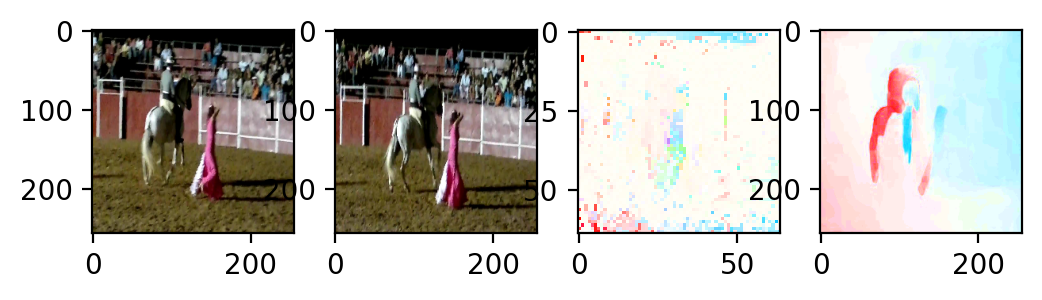

In [621]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 1, 1, 1), out_indices=(3, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d2_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_mast_2/epoch_3200.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
main_hr(x1_lab, x2_lab, model, frame1, frame2, gt)

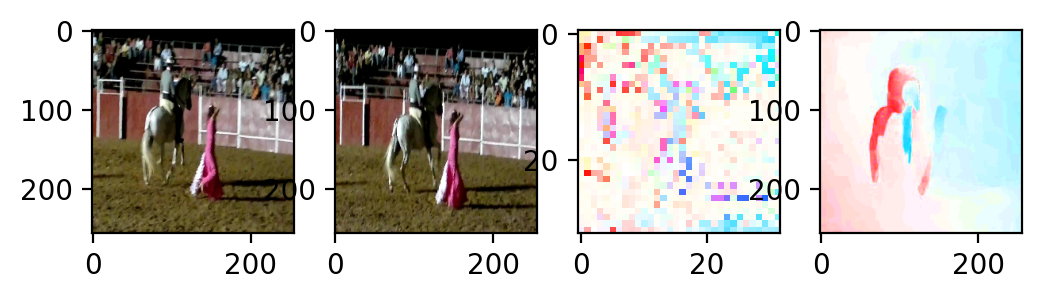

In [622]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_mast_12_2/epoch_1600.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
main(x1_lab, x2_lab, model, frame1, frame2, gt)

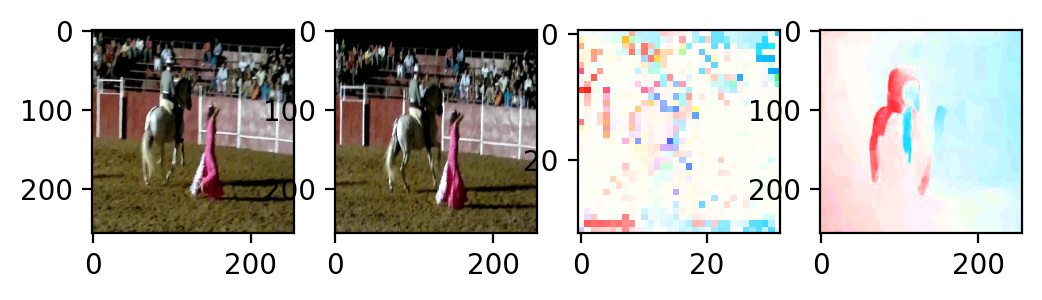

In [623]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_mast_14/epoch_1600.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
main(x1_lab, x2_lab, model, frame1, frame2, gt)

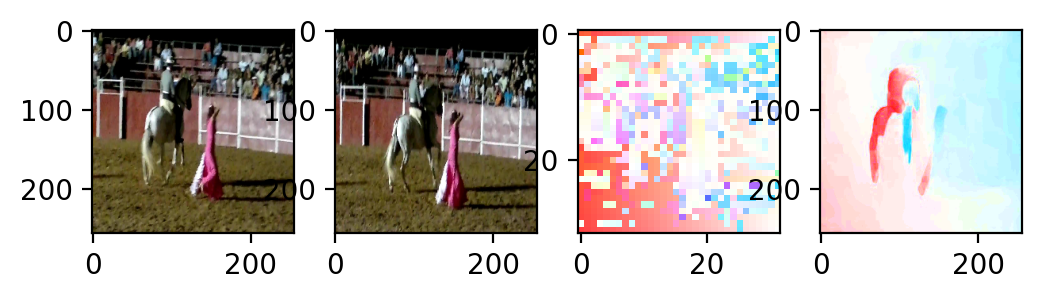

In [624]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/train_vqvae_video_d4_nemd2048_contrastive_byol_commit1.0_v2/epoch_3200.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
main(x1_rgb, x2_rgb, model, frame1, frame2, gt)